<a href="https://colab.research.google.com/github/IgorShestov/pet-projects/blob/main/Bad_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вступление
В социальной сети "Одноклассники" пользователи ежедневно публикуют огромное количество комментариев разного направления и характера. Для повышения качества контента создатели сети запустили платформу "Робби" на базе нейросетей. На основе анализа контента платформой был сгенерирован набор данных, содержащий комментарии пользователей социальной сети. 

Мне предстоит спроектировать и создать ML модель, которая умеет находить непристойные комментарии среди всего набора данных и классифицировать их по классам: 

* Оскорбление    / insult
* Угроза         / threat
* Непростойность / obscenity
* Нормальные     / normal

In [ ]:
pip install scipy==1.1.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [ ]:

# основные
import pandas as pd 
import numpy as np

# разное
import gc
import time
import warnings
from random import choice

# статистика
from scipy import sparse
import scipy.stats as ss

# отображение
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re    # для регулирования
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# настройки
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
stopwords = set(stopwords.words('russian') )
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# пожгружаюем данные
train= pd.read_csv('../input/comment/train.txt', sep='\t', error_bad_lines=False,  names = ["id", "label", "comment"])
test = pd.read_csv('../input/comment/data.txt' , sep='\t', error_bad_lines=False,  names = ["id", "comment"])

### Классовый дисбаланс::

In [ ]:
# берем случайны образец
train.sample(10)

,id,label,comment
31345,4674,__label__NORMAL,не завидуй...
31198,177635,__label__NORMAL,ещё надо. порабртать
33592,167484,__label__NORMAL,действительно бред какой то видеть белорусский...
13284,120197,__label__NORMAL,"жуть.маленький садист.думаю,что это фотошоп."
132635,60113,__label__NORMAL,но они забавные:)
52840,164497,__label__NORMAL,какой талант действительно супер
89682,185774,__label__NORMAL,я конечно не знаю.но меня очень пугает нынешни...
53024,170975,__label__NORMAL,очень даже ем!😂
62851,147425,__label__OBSCENITY,__label__THREAT
36010,51333,__label__NORMAL,оплата когда прийдут


In [ ]:
test.sample(10)

,id,comment
122897,181302,на главное класс взаимно
1576,102310,вот таким надо быть ! супер!
106649,132613,"все у началочки интересно,а во учитель по русс..."
234765,207354,"да, кошки чистоплотные животные от природы."
127085,188297,какая лапочка-липунюшечка...!
23690,231175,"будте позорище и люди потянутся, а разве не см..."
54400,241993,да когда же она исчезнет совсем
205147,183866,где же выход если мы не способны к нормальной ...
172462,212058,"не знаю даже , где то читана девочки и по меся..."
240802,243210,"людей искренне жалко... знаю, что такое в проб..."


In [ ]:
# проверка на пропущенные значения
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       148775 non-null  int64 
 1   label    148775 non-null  object
 2   comment  148775 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.4+ MB


In [ ]:
# типы маркировок
train.label.value_counts()

__label__NORMAL       122194
__label__INSULT        21952
__label__THREAT         3263
__label__OBSCENITY      1366
Name: label, dtype: int64

Данные содержат 1 столбец с метками. Создадим 4 и изменим их метки с 0 на 1

In [ ]:
train['normal']=train['label']
train['insult']=train['label']
train['threat']=train['label']
train['obscenity']=train['label']

In [ ]:
n = {'__label__NORMAL':1,'__label__INSULT':0,'__label__THREAT':0, '__label__OBSCENITY':0}
i = {'__label__NORMAL':0,'__label__INSULT':1,'__label__THREAT':0, '__label__OBSCENITY':0}
t = {'__label__NORMAL':0,'__label__INSULT':0,'__label__THREAT':1, '__label__OBSCENITY':0}
o = {'__label__NORMAL':0,'__label__INSULT':0,'__label__THREAT':0, '__label__OBSCENITY':1}

In [ ]:
train['normal']=train['normal'].replace(n)

In [ ]:
train['insult']=train['insult'].replace(i)

In [ ]:
train['threat']=train['threat'].replace(t)

In [ ]:
train['obscenity']=train['obscenity'].replace(o)

In [ ]:
# дотаточно топорно, изменить на что-то изящней
train.drop(columns='label', inplace=True)

In [ ]:
train.head()

,id,comment,normal,insult,threat,obscenity
0,41127,дворника надо тоже уничтожить!,0,0,1,0
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,0,0,0
2,6256,полностью с вами согласна!,1,0,0,0
3,189636,"хоть ногу вверх, ничего не изменится",1,0,0,0
4,99053,а что значит - левого ребенка?,1,0,0,0


In [ ]:
x=train.iloc[:,2:].sum()
# поиск комментарии без каких-либо тегов как "чистые"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
# сумма "чистых" коментариев 
train['clean'].sum()
print("Общее кол. коментариев = ",len(train))
print("Общее кол. пропушеных коментарие = ",train['clean'].sum())
print("Общее кол. заполненых коментарие =",x.sum())

Общее кол. коментариев =  148775
Общее кол. пропушеных коментарие =  0
Общее кол. заполненых коментарие = 148775


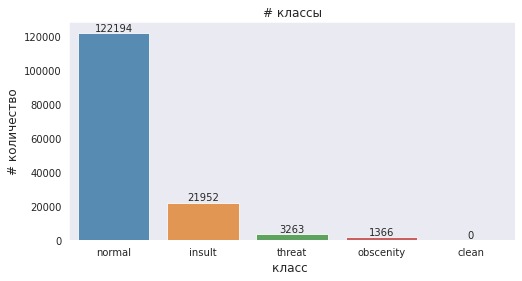

In [ ]:
x=train.iloc[:,2:].sum()
# plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# классы")
plt.ylabel('# количество', fontsize=12)
plt.xlabel('класс ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

* Неготивные коментарии неравномерно распределена по классам. Следовательно, мы можем столкнуться с проблемами классового дисбаланса
* В наборе данных для обучения содержится ~149  тыс. комментариев, из них  ~122 тыс. нормальные, а ~27 тыс. неготивные.


## Примеры коментариев:

In [ ]:
print("Нормальный:")
print(train[train.normal==1].iloc[2,1])

Нормальный:
хоть ногу вверх, ничего не изменится


In [ ]:
print("Грубый:")
print(train[train.insult==1].iloc[3,1])

Грубый:
долбаеб . тебе насрать на слезы матери . видать хорошо пилоткой хорошо накрыла тебя


In [ ]:
print("Угрожающий:")
print(train[train.threat==1].iloc[5,1])

Угрожающий:
такого полицейского убить надо было


In [ ]:
print("Непристойный:")
print(train[train.obscenity==1].iloc[4,1])

Непристойный:
мигранты выебет тебе


Это была целая куча токсичности. Некоторые странные наблюдения:

* Некоторые комментарии являются исключительно и просто копипастом одного и того же



# Облака слов - Частые слова:

Теперь взглянем на слова, которые связаны с этими классами.


In [ ]:
!ls ../input/imagesforkernal/
stopword=set(STOPWORDS)

ls: cannot access '../input/imagesforkernal/': No such file or directory


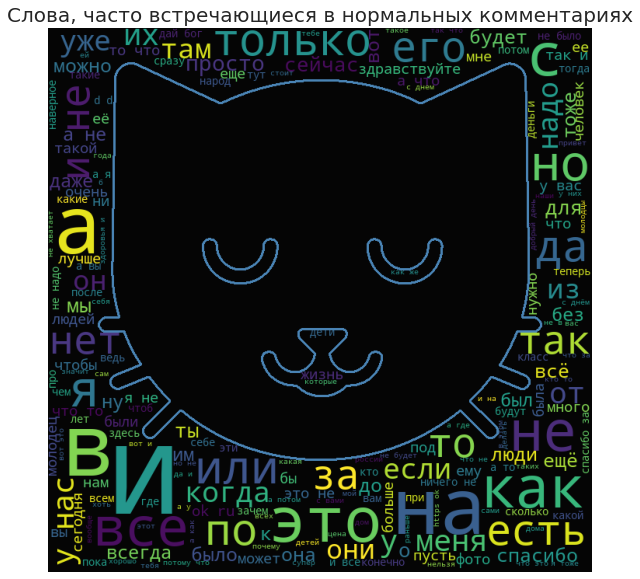

In [ ]:
# нормальные коментарии
normal_mask=np.array(Image.open("../input/comment/Relax Cat.png"))
# облако слов для нормальных коментариев
subset=train[train.normal==True]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=normal_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Слова, часто встречающиеся в нормальных комментариях", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=2), alpha=0.98)
plt.show()

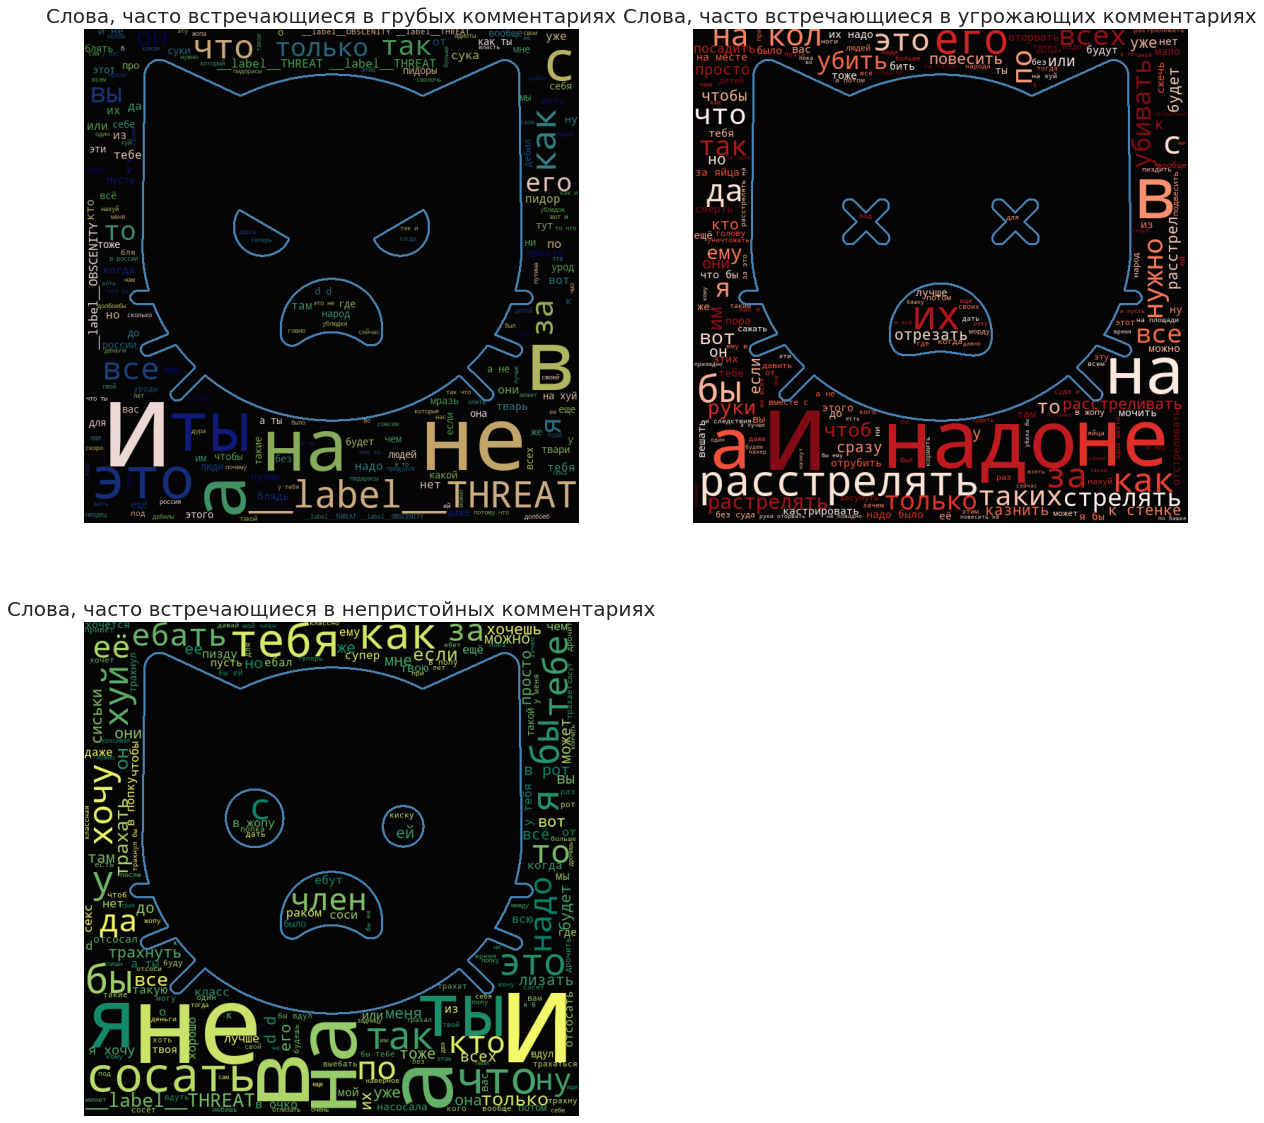

In [ ]:
# грубые коментари
insult_mask=np.array(Image.open("../input/comment/Hungry cat.png"))
insult_mask=insult_mask[:,:,1]
# облако слов для грубых коментариев
subset=train[train.insult==1]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=insult_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Слова, часто встречающиеся в грубых комментариях", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

# угрожающие коментарии
plt.subplot(222)
threat_mask=np.array(Image.open("../input/comment/Dead Cat.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=threat_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Слова, часто встречающиеся в угрожающих комментариях", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=2), alpha=0.98)

# непристойные коментарии
plt.subplot(223)
obscenity_mask=np.array(Image.open("../input/comment/Freak Cat.png"))
obscenity_mask=obscenity_mask[:,:,1]
subset=train[train.obscenity==1]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=obscenity_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Слова, часто встречающиеся в непристойных комментариях", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2), alpha=0.98)



В изображении insult и obscenity видим артефакты а именно ' __ label __THREAT ' изучи их внимательней

In [ ]:
train[train.insult==1].comment.value_counts()

__label__THREAT                                                                                                  3747
__label__OBSCENITY                                                                                               1198
послушай да как к тебе зайти почему всё зашифрованно какая хуй разница всё равно все шлюхи                          1
ну и дура. а пафоса сколько....аж тошнит                                                                            1
ты только прыщей на жопе можешь давить своему партнеру,исчезни поролоновый.                                         1
                                                                                                                 ... 
ни хуя себе...........                                                                                              1
сучара необыкновенная                                                                                               1
сволочь этот депутат                                    

In [ ]:
train[train.obscenity==1].comment.value_counts()

__label__THREAT                                                                                               43
если канкеритни мужик нужин 4 раз усраветь кажде день по трахнут                                               1
ммм не атказалсябы трахнуть такую попку                                                                        1
юбать и юбать надо не поднимая головы                                                                          1
что девка сиську показала .это не значит ни чего .ведь ты же в маске милый хлоопчик и пососать не суждено.     1
                                                                                                              ..
солдату за отаку - хуй в сраку !!! а маньке за пизду - красную звезду ............                             1
ебать хорошо и лизать                                                                                          1
о трахат бы такую.                                                                              

Проверим отсальные комментарии на артифакты

In [ ]:
train[train.normal==1].comment.value_counts()

о времена! о нравы! :-(                                                                                                                                                                                                                                                                                                                                                    1
для народа а зачем народ и это схавает.                                                                                                                                                                                                                                                                                                                                    1
и привыкнуть к амурской водки.                                                                                                                                                                                                                                                

In [ ]:
train[train.threat==1].comment.value_counts()

таких сразу растреливать надо                                                                                                   1
взять и закатать катком нахер, я вообще сочувствую русским кто там живёт, грязь, кругом кучи иностранцев, давайте уже домой.    1
наверно пора желтопузых мочить                                                                                                  1
вот это кликануло её пора убивать                                                                                               1
стрелять нах всех через одного                                                                                                  1
                                                                                                                               ..
вас самих надо на вилы!!!                                                                                                       1
пристрелите его чтоб не мучился бедолага.                                                 

In [ ]:
train.sample(5)

,id,comment,normal,insult,threat,obscenity,clean
7483,93603,идет до хаты вомпир волохатый. рученьки хрум х...,1,0,0,0,False
28744,69230,черемшанка позвоните или напишите телефон созв...,1,0,0,0,False
85653,196086,"курва галичанская , приехала в одессу со своим...",0,1,0,0,False
71903,196515,в каком году она пропала?,1,0,0,0,False
108405,229837,продается ваз 2114 черного цвета 2008 года за ...,1,0,0,0,False


Отлично! 
мы нашли дефекты в коментариях.

Всего девиантных коментариев:

    Insilt - 4945
    Obscenity - 43    
Я вижу два пути решения удаления этих строк и замена на аналогичные коментарии.

По скольку данных не так много процент девиантных коментариев может быть велик, проверим.


In [ ]:
4945 / train[train.insult==1].comment.count() *100

22.526421282798832

In [ ]:
# проверяем количество коментариев
print(train[train.comment=='__label__OBSCENITY'].shape)
print(train[train.comment=='__label__THREAT'].shape)

(1198, 7)
(3790, 7)


 22.5 процента относительно  много.
Принимаю решение заменить данные коментарии, на случайно выбраные из очишеных коментариев.



In [ ]:
train.comment.value_counts()

__label__THREAT                                                            3790
__label__OBSCENITY                                                         1198
о времена! о нравы! :-(                                                       1
не понятно, чьи это корни, ну, точно не луковицы лилии                        1
очкуют пидорасы за свою жопаньку..                                            1
                                                                           ... 
сам ты тварь конченная..                                                      1
здравствуйте! девочки, есть у нас налоговики?? один вопрос нужно задать       1
какой молодец. будем жить дружно ребята.                                      1
и где столкновение? зря потратил время                                        1
лизавета весь диплом в одного сжевала(fr)                                     1
Name: comment, Length: 143789, dtype: int64

In [ ]:
drop__label__OBSCENITY =train[train.comment=='__label__OBSCENITY']
drop__label__THREAT =train[train.comment=='__label__THREAT']

In [ ]:
comment_clean= train.drop(drop__label__THREAT.index, axis=0)
comment_clean= comment_clean.drop(drop__label__OBSCENITY.index, axis=0)

In [ ]:
list_comment_clean_insult = comment_clean[comment_clean.insult==1].comment.tolist()

In [ ]:
comment_clean[comment_clean.insult==1].comment.value_counts()

послушай да как к тебе зайти почему всё зашифрованно какая хуй разница всё равно все шлюхи                                                                                                                                                                                                                                                        1
мразь на зону его пидора                                                                                                                                                                                                                                                                                                                          1
ты сука ебнутая, живёшь вот и живи в своей стороне, не знаешь что происходит, нечего свой длинный язык сунуть, куда не надо, тебя в окрестино пасадить, где мирный нород страдает от силовиков,, а тебя пустят погругу, а их наградят за это                                                                                    

In [ ]:
# не смог найти более изящного способа нежели цикл.есть куда рости)
x=0
while x<148775:
  if train.comment[x] == '__label__THREAT':
    train.comment[x] = choice(list_comment_clean_insult)
  x+=1

In [ ]:
i=0
while i<148775:
  if train.comment[i] == '__label__OBSCENITY':
    train.comment[i] = choice(list_comment_clean_insult)
  i+=1

In [ ]:
# проверяем успешность удаления коментариев
print(train[train.comment=='__label__OBSCENITY'].shape)
print(train[train.comment=='__label__THREAT'].shape)

(0, 7)
(0, 7)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         148775 non-null  int64 
 1   comment    148775 non-null  object
 2   normal     148775 non-null  int64 
 3   insult     148775 non-null  int64 
 4   threat     148775 non-null  int64 
 5   obscenity  148775 non-null  int64 
 6   clean      148775 non-null  bool  
dtypes: bool(1), int64(5), object(1)
memory usage: 7.0+ MB


In [ ]:
train.head()

,id,comment,normal,insult,threat,obscenity,clean
0,41127,дворника надо тоже уничтожить!,0,0,1,0,False
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,0,0,0,False
2,6256,полностью с вами согласна!,1,0,0,0,False
3,189636,"хоть ногу вверх, ничего не изменится",1,0,0,0,False
4,99053,а что значит - левого ребенка?,1,0,0,0,False



# Разработка фичей:

## Косвенные характеристики:
Еще несколько экспериментальных функций.
* количество предложений
* количество слов
* количество уникальных слов
* количество букв
* количество знаков препинания
* количество прописных слов/букв
* количество стоп-слов
* Средняя длина каждого слова




In [ ]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [ ]:
df.sample(5)

,id,comment
259491,111307,"молодежи фургал по хрену,живет будущее по свои..."
280306,243915,ну насчёт толщины асфальта не 5см а 10см
346842,148472,это вы правильно говорите!!! заменить его на д...
83446,186652,детки совсем не в маму
85468,117578,159) статусы и самые разные поздравления


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397065 entries, 0 to 397064
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       397065 non-null  int64 
 1   comment  397065 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [ ]:

#Количество отправленных сообщений в каждом комментарии:
  # '\n' можно использовать для подсчета количества предложений в каждом комментарии
df['count_sent']=df["comment"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Количество слов в каждом комментарии:
df['count_word']=df["comment"].apply(lambda x: len(str(x).split()))
#Уникальное количество слов
df['count_unique_word']=df["comment"].apply(lambda x: len(set(str(x).split())))
#Количество букв
df['count_letters']=df["comment"].apply(lambda x: len(str(x)))
#количество знаков препинания
df["count_punctuations"] =df["comment"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#Количество стоп-слов
df["count_stopwords"] = df["comment"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
#Средняя длина слов
df["mean_word_len"] = df["comment"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#производные функции
#Процентное количество слов в каждом комментарии:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#производные функции
#Проценты пунктуации в каждом комментарии:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [ ]:
#отдельные функции обучения и тестирования
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#присоединяйтесь к тегам
train_tags=train.iloc[:,2:]


In [ ]:
train_feats

,id,comment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,41127,дворника надо тоже уничтожить!,1,4,4,30,1,2,6.750000,100.000000,25.000000
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,28,28,195,8,7,6.000000,100.000000,28.571429
2,6256,полностью с вами согласна!,1,4,4,26,1,1,5.750000,100.000000,25.000000
3,189636,"хоть ногу вверх, ничего не изменится",1,6,6,36,1,3,5.166667,100.000000,16.666667
4,99053,а что значит - левого ребенка?,1,6,6,30,2,2,4.166667,100.000000,33.333333
...,...,...,...,...,...,...,...,...,...,...,...
148770,99767,"а вы думаете что полиция об этом не знает, про...",1,42,40,235,7,18,4.619048,95.238095,16.666667
148771,87456,"ну а что вы тут возмущаетесь , все ведь точно ...",1,14,13,58,3,8,3.214286,92.857143,21.428571
148772,185614,затерли до дыр данный ролик сколько лет ему уж...,1,19,19,107,1,7,4.684211,100.000000,5.263158
148773,86412,если проследят за пидором то накажут,1,6,6,36,0,3,5.166667,100.000000,0.000000


In [ ]:
train_tags

,normal,insult,threat,obscenity,clean
0,0,0,1,0,False
1,1,0,0,0,False
2,1,0,0,0,False
3,1,0,0,0,False
4,1,0,0,0,False
...,...,...,...,...,...
148770,1,0,0,0,False
148771,1,0,0,0,False
148772,1,0,0,0,False
148773,0,1,0,0,False


In [ ]:
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [ ]:
pd.concat([train_feats,train_tags],axis=1)

,id,comment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,...,normal,insult,threat,obscenity,clean,normal,insult,threat,obscenity,clean
0,41127,дворника надо тоже уничтожить!,1,4,4,30,1,2,6.750000,100.000000,...,0,0,1,0,False,0,0,1,0,False
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,28,28,195,8,7,6.000000,100.000000,...,1,0,0,0,False,1,0,0,0,False
2,6256,полностью с вами согласна!,1,4,4,26,1,1,5.750000,100.000000,...,1,0,0,0,False,1,0,0,0,False
3,189636,"хоть ногу вверх, ничего не изменится",1,6,6,36,1,3,5.166667,100.000000,...,1,0,0,0,False,1,0,0,0,False
4,99053,а что значит - левого ребенка?,1,6,6,30,2,2,4.166667,100.000000,...,1,0,0,0,False,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148770,99767,"а вы думаете что полиция об этом не знает, про...",1,42,40,235,7,18,4.619048,95.238095,...,1,0,0,0,False,1,0,0,0,False
148771,87456,"ну а что вы тут возмущаетесь , все ведь точно ...",1,14,13,58,3,8,3.214286,92.857143,...,1,0,0,0,False,1,0,0,0,False
148772,185614,затерли до дыр данный ролик сколько лет ему уж...,1,19,19,107,1,7,4.684211,100.000000,...,1,0,0,0,False,1,0,0,0,False
148773,86412,если проследят за пидором то накажут,1,6,6,36,0,3,5.166667,100.000000,...,0,1,0,0,False,0,1,0,0,False


In [ ]:
train_feats

,id,comment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent,normal,insult,threat,obscenity,clean
0,41127,дворника надо тоже уничтожить!,1,4,4,30,1,2,6.750000,100.000000,25.000000,0,0,1,0,False
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,28,28,195,8,7,6.000000,100.000000,28.571429,1,0,0,0,False
2,6256,полностью с вами согласна!,1,4,4,26,1,1,5.750000,100.000000,25.000000,1,0,0,0,False
3,189636,"хоть ногу вверх, ничего не изменится",1,6,6,36,1,3,5.166667,100.000000,16.666667,1,0,0,0,False
4,99053,а что значит - левого ребенка?,1,6,6,30,2,2,4.166667,100.000000,33.333333,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148770,99767,"а вы думаете что полиция об этом не знает, про...",1,42,40,235,7,18,4.619048,95.238095,16.666667,1,0,0,0,False
148771,87456,"ну а что вы тут возмущаетесь , все ведь точно ...",1,14,13,58,3,8,3.214286,92.857143,21.428571,1,0,0,0,False
148772,185614,затерли до дыр данный ролик сколько лет ему уж...,1,19,19,107,1,7,4.684211,100.000000,5.263158,1,0,0,0,False
148773,86412,если проследят за пидором то накажут,1,6,6,36,0,3,5.166667,100.000000,0.000000,0,1,0,0,False


In [ ]:
train_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   148775 non-null  int64  
 1   comment              148775 non-null  object 
 2   count_sent           148775 non-null  int64  
 3   count_word           148775 non-null  int64  
 4   count_unique_word    148775 non-null  int64  
 5   count_letters        148775 non-null  int64  
 6   count_punctuations   148775 non-null  int64  
 7   count_stopwords      148775 non-null  int64  
 8   mean_word_len        148775 non-null  float64
 9   word_unique_percent  148775 non-null  float64
 10  punct_percent        148775 non-null  float64
 11  normal               148775 non-null  int64  
 12  insult               148775 non-null  int64  
 13  threat               148775 non-null  int64  
 14  obscenity            148775 non-null  int64  
 15  clean            

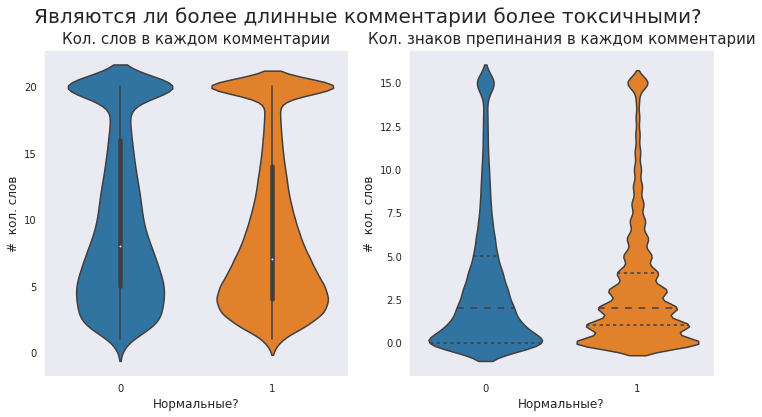

In [ ]:
train_feats['count_word'].loc[train_feats['count_word']>20] = 20 
plt.figure(figsize=(12,6))
## послания
plt.subplot(121)
plt.suptitle("Являются ли более длинные комментарии более токсичными?",fontsize=20)
sns.violinplot(y='count_word',x='normal', data=train_feats,split=True)
plt.xlabel('Нормальные?', fontsize=12)
plt.ylabel('#  кол. слов', fontsize=12)
plt.title("Кол. слов в каждом комментарии", fontsize=15)
# слова
train_feats['count_punctuations'].loc[train_feats['count_punctuations']>15] = 15
plt.subplot(122)
sns.violinplot(y='count_punctuations',x='normal', data=train_feats,split=True,inner="quart")
plt.xlabel('Нормальные?', fontsize=12)
plt.ylabel('#  кол. слов', fontsize=12)
plt.title("Кол. знаков препинания в каждом комментарии", fontsize=15)

plt.show()

Длинные предложения или большее количество слов, по-видимому, не являются существенным показателем токсичности.


In [ ]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#подготовка к разделению скрипичных сюжетов
#для желаемых графиков данные должны быть в длинном формате
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='normal')
#спамеры - комментарии с менее чем 30% уникальных слов
spammers=train_feats[train_feats['word_unique_percent']<30]

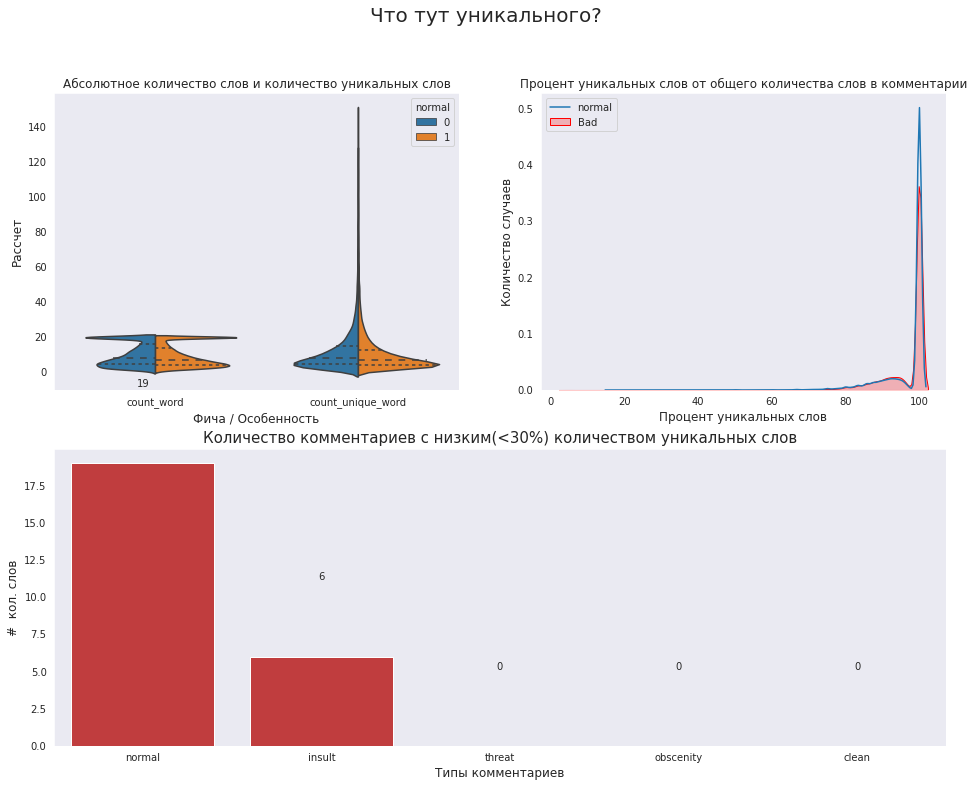

In [ ]:
plt.figure(figsize=(16,12))
plt.suptitle("Что тут уникального?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='normal', data=temp_df,split=True,inner='quartile')
plt.title("Абсолютное количество слов и количество уникальных слов")
plt.xlabel('Фича / Особенность', fontsize=12)
plt.ylabel('Рассчет', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Процент уникальных слов от общего количества слов в комментарии")
ax=sns.kdeplot(train_feats[train_feats.normal == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.normal == 1].word_unique_percent, label="normal")
plt.legend()
plt.ylabel('Количество случаев', fontsize=12)
plt.xlabel('Процент уникальных слов', fontsize=12)

x=spammers.iloc[:,-5:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Количество комментариев с низким(<30%) количеством уникальных слов",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#добавление текстовых меток
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Типы комментариев', fontsize=12)
plt.ylabel('#  кол. слов', fontsize=12)
plt.show()

### Кол. слов VS Кол. уникальных слов:
Наблюдаются заметные сдвиги в начале(5-7) как по количеству слов, так и по количеству уникальных слов в чистых и токсичных комментариях.
   
### Уникальный процент количества слов:
ДИаграмы практически совпадают.

# Спамеры более токсичные
Взглянем на примеры спама.

In [ ]:
print("Обычный пример спама:")
print(spammers[spammers.normal==1].comment.iloc[6])
print("Пример грубого спама:")
print(spammers[spammers.insult==1].comment.iloc[3])

Обычный пример спама:
поздравпяем!!!!! 🌹 🌹 🌹 🌹 🌹 🌹 🌹
Пример грубого спама:
императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура


# Спам токсичен для модели!

Это может привести к переобучению модели.


# Базовая модель:

In [ ]:

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    

In [ ]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_stopwords', 
       'mean_word_len', 'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]


TARGET_COLS=['insult', 'threat', 'obscenity']
target_y=train_tags[TARGET_COLS]


In [ ]:
target_x

,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,1,4,4,30,1,2,6.750000,100.000000,25.000000
1,1,20,28,195,8,7,6.000000,100.000000,28.571429
2,1,4,4,26,1,1,5.750000,100.000000,25.000000
3,1,6,6,36,1,3,5.166667,100.000000,16.666667
4,1,6,6,30,2,2,4.166667,100.000000,33.333333
...,...,...,...,...,...,...,...,...,...
148770,1,20,40,235,7,18,4.619048,95.238095,16.666667
148771,1,14,13,58,3,8,3.214286,92.857143,21.428571
148772,1,19,19,107,1,7,4.684211,100.000000,5.263158
148773,1,6,6,36,0,3,5.166667,100.000000,0.000000


In [ ]:
target_y

,insult,threat,obscenity
0,0,1,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
148770,0,0,0
148771,0,0,0
148772,0,0,0
148773,1,0,0


In [ ]:
#Только косвенные признаки -- мета-функции
print("Использование только косвенных функций")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('среднее значение по столбцам log loss:Train dataset', np.mean(train_loss))
print('среднее значение по столбцам log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("общее время до модели косвенного подвига",end_time-start_time)

Использование только косвенных функций
Class:= insult
Trainloss=log loss: 0.41578382671829
Validloss=log loss: 0.41793324954153344
Class:= threat
Trainloss=log loss: 0.10429512277105314
Validloss=log loss: 0.10466659142892128
Class:= obscenity
Trainloss=log loss: 0.05118832168928988
Validloss=log loss: 0.04790793804716324
среднее значение по столбцам log loss:Train dataset 0.19042242372621102
среднее значение по столбцам log loss:Validation dataset 0.1901692596725393
общее время до модели косвенного подвига 76.44206213951111


In [ ]:
importance[0][0]

array([-0.24828096,  0.0124953 ,  0.0555361 , -0.00806796,  0.0325852 ,
       -0.00405245,  0.05431801, -0.01796864, -0.00153745])

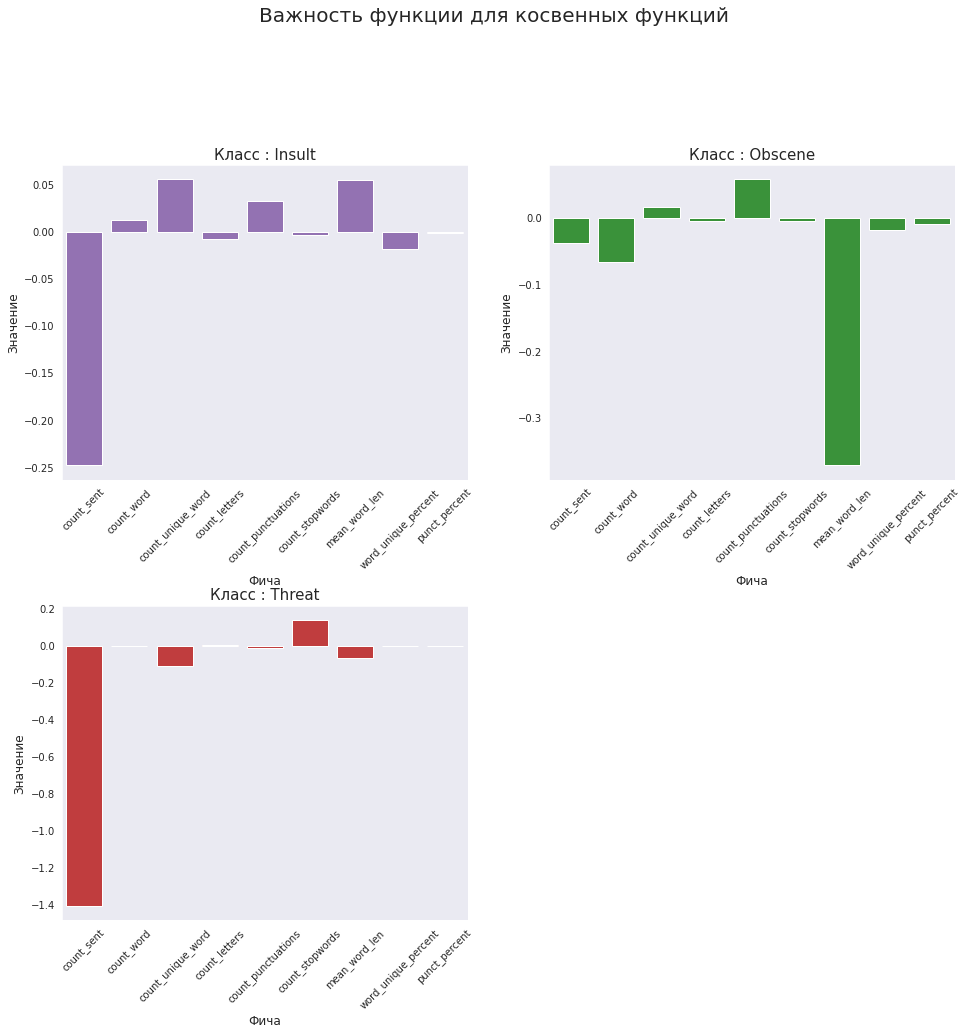

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("Важность функции для косвенных функций",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)

plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[4])
plt.title("Класс : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Фича', fontsize=12)
plt.ylabel('Значение', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("Класс : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Фича', fontsize=12)
plt.ylabel('Значение', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[3])
plt.title("Класс : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Фича', fontsize=12)
plt.ylabel('Значение', fontsize=12)


plt.show()